In [1]:
# !pip list -v

In [2]:
!pip install talib-binary
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 22.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
!pip install --upgrade pandas-datareader
!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 36.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import talib as ta
import joblib
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import yfinance as yahoo_finance

In [5]:
#suppress 'SettingWithCopy' warning
pd.set_option('mode.chained_assignment', None)

In [6]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

In [8]:
# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False) 

In [9]:
#optional 
#yahoo_finance.pdr_override()

In [10]:
%matplotlib inline

In [11]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [12]:
# ___variables___
#ticker = 'TSLA'
#ticker = 'AAPL'
#ticker = 'NFLX'
#ticker = 'MSFT'
#ticker = 'NFLX'
#ticker = 'GOOGL'
#ticker = 'AMZN'
# ticker = 'MOS'
#ticker = 'TLT'
#ticker = 'IBM'
#ticker = 'F'
#ticker = 'C'
#ticker = 'PG'
#ticker = 'JNJ'
# ticker = 'SWK' # Stanley Black & Decker
# ticker = "PPIACO" # PPI

start_time = datetime.datetime(1970, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

In [13]:
def get_data(ticker):
    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            connected = True
            print('connected to yahoo')
        except Exception as e:
            print("type error: " + str(e))
            time.sleep( 5 )
            pass   

    # use numerical integer index instead of date    
    df = df.reset_index()
    #print(df.head(5))
    return df

In [14]:
# df = get_data(ticker)

In [15]:
# df.head()

In [16]:
# df.sort_values(by="Date", inplace=True)

In [17]:
# df.head()

### Compute various stock technical indicators
For each stock we compute several technical indicators, we use mainly exponential moving averages, Bollinger Bands, RSI and so on. We will then feed these into neural network as features (or values derived from these indicators).

In [18]:
def compute_technical_indicators(df):
    df['EMA5'] = ta.EMA(df['Adj Close'].values, timeperiod=5)
    df['EMA10'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    df['EMA15'] = ta.EMA(df['Adj Close'].values, timeperiod=15)
    df['EMA20'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    df['EMA30'] = ta.EMA(df['Adj Close'].values, timeperiod=30)
    df['EMA40'] = ta.EMA(df['Adj Close'].values, timeperiod=40)
    df['EMA50'] = ta.EMA(df['Adj Close'].values, timeperiod=50)

    df['EMA60'] = ta.EMA(df['Adj Close'].values, timeperiod=60)
    df['EMA70'] = ta.EMA(df['Adj Close'].values, timeperiod=70)
    df['EMA80'] = ta.EMA(df['Adj Close'].values, timeperiod=80)
    df['EMA90'] = ta.EMA(df['Adj Close'].values, timeperiod=90)
    
    df['EMA100'] = ta.EMA(df['Adj Close'].values, timeperiod=100)
    df['EMA150'] = ta.EMA(df['Adj Close'].values, timeperiod=150)
    df['EMA200'] = ta.EMA(df['Adj Close'].values, timeperiod=200)

    df['upperBB'], df['middleBB'], df['lowerBB'] = ta.BBANDS(df['Adj Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    df['SAR'] = ta.SAR(df['High'].values, df['Low'].values, acceleration=0.02, maximum=0.2)

    # we will normalize RSI
    df['RSI'] = ta.RSI(df['Adj Close'].values, timeperiod=14)

    df['normRSI'] = ta.RSI(df['Adj Close'].values, timeperiod=14) / 100.0
    
    df.tail()

    return df

In [19]:
# df = compute_technical_indicators(df)

In [20]:
# df.tail()

In [21]:
def compute_features(df):
    # computes features for forest decisions
    df['aboveEMA5'] = np.where(df['Adj Close'] > df['EMA5'], 1, 0)
    df['aboveEMA10'] = np.where(df['Adj Close'] > df['EMA10'], 1, 0)
    df['aboveEMA15'] = np.where(df['Adj Close'] > df['EMA15'], 1, 0)
    df['aboveEMA20'] = np.where(df['Adj Close'] > df['EMA20'], 1, 0)
    df['aboveEMA30'] = np.where(df['Adj Close'] > df['EMA30'], 1, 0)
    df['aboveEMA40'] = np.where(df['Adj Close'] > df['EMA40'], 1, 0)
    
    df['aboveEMA50'] = np.where(df['Adj Close'] > df['EMA50'], 1, 0)
    df['aboveEMA60'] = np.where(df['Adj Close'] > df['EMA60'], 1, 0)
    df['aboveEMA70'] = np.where(df['Adj Close'] > df['EMA70'], 1, 0)
    df['aboveEMA80'] = np.where(df['Adj Close'] > df['EMA80'], 1, 0)
    df['aboveEMA90'] = np.where(df['Adj Close'] > df['EMA90'], 1, 0)
    
    df['aboveEMA100'] = np.where(df['Adj Close'] > df['EMA100'], 1, 0)
    df['aboveEMA150'] = np.where(df['Adj Close'] > df['EMA150'], 1, 0)
    df['aboveEMA200'] = np.where(df['Adj Close'] > df['EMA200'], 1, 0)

    df['aboveUpperBB'] = np.where(df['Adj Close'] > df['upperBB'], 1, 0)
    df['belowLowerBB'] = np.where(df['Adj Close'] < df['lowerBB'], 1, 0)
    
    df['aboveSAR'] = np.where(df['Adj Close'] > df['SAR'], 1, 0)
   
    df['oversoldRSI'] = np.where(df['RSI'] < 30, 1, 0)
    df['overboughtRSI'] = np.where(df['RSI'] > 70, 1, 0)


    # very important - cleanup NaN values, otherwise prediction does not work
    df=df.fillna(0).copy()
    
    df.tail()

    return df

In [22]:
# df = compute_features(df)

In [23]:
# df.tail()

In [24]:
def plot_train_data(df):
    # plot price
    plt.figure(figsize=(15,2.5))
    plt.title("Stock data " + str(ticker))
    plt.plot(df["Date"], df["Adj Close"])
    # plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()
    return None

In [25]:
def define_target_condition(df):
    # price higher later - bad predictive results
    # df["target_cls"] = np.where(df["Adj Close"].shift(-34) > df["Adj Close"], 1, 0)
    
    # price above trend multiple days later
    df["target_cls"] = np.where(df["Adj Close"].shift(-34) > df["EMA150"].shift(-34), 1, 0)
    
    # important - remove NaN values
    df = df.fillna(0).copy()
    
    df.tail()
    
    return df

In [26]:
# df = define_target_condition(df)

In [27]:
# df.tail()

In [28]:
# plot_train_data(df)

### Create one big training dataframe
Neural network will be trained on this dataframe. Data will be split eventually into training and testing set.

In [33]:
tickers = ['F', 'IBM', 'GE', 'AAPL', 'ADM', "C", "TLT", "AAP", "ORLY", "EPD",
           'XOM', 'GM','MMM','KO','PEP','SO','GS',
          'HAS','PEAK','HPE','HLT','HD','HON','HRL','HST','HPQ','HUM','ILMN', 
          'INTC','ICE','INTU','ISRG','IVZ','IRM','JNJ','JPM','JNPR','K','KMB', 
          'KIM', 'KMI','KSS','KHC', 'KR',
          'LEG', 'LIN', 'LMT','LOW',
          'MAR', 'MA','MCD','MDT', 'MRK',
          'MET', 'MGM', 'MU','MSFT', 'MAA',
          "SBK", "PG",
          'MNST', 'MCO','MS', 'MSI', 
          'MMM', 'ABT','ACN','ATVI','ADBE','AMD','A','AKAM','ARE','GOOG','AMZN','AAL',]

In [32]:
# parent dataframe to append to
ticker = "SPY"
df = get_data(ticker)
df = compute_technical_indicators(df)
df = compute_features(df)
df = define_target_condition(df)

connected to yahoo


In [34]:
for ticker in tickers:
    t_df = get_data(ticker)
    t_df = compute_technical_indicators(t_df)
    t_df = compute_features(t_df)
    t_df = define_target_condition(t_df)
    
    df = pd.concat([df, t_df], ignore_index=True)

connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to

In [35]:
df.tail()

Date   High    Low   Open    Close      Volume  Adj Close       EMA5      EMA10      EMA15  ...  aboveEMA90  aboveEMA100  aboveEMA150  aboveEMA200  aboveUpperBB  belowLowerBB  aboveSAR  oversoldRSI  overboughtRSI  target_cls
673858 2022-08-04  14.97  14.51  14.53  14.8600  27102900.0    14.8600  14.425516  14.256627  14.198821  ...           0            0            0            0             0             0         1            0              0           0
673859 2022-08-05  14.98  14.61  14.62  14.7400  19477500.0    14.7400  14.530344  14.344513  14.266468  ...           0            0            0            0             0             0         1            0              0           0
673860 2022-08-08  15.28  14.82  14.87  15.0200  23643500.0    15.0200  14.693563  14.467329  14.360660  ...           0            0            0            0             0             0         1            0              0           0
673861 2022-08-09  14.88  14.38  14.87  14.6200  23688300.0    14.6200  14.669042  14.495087  14.393077  ...           0            0            0            0             0             0         1            0              0           0
673862 2022-08-10  15.39  14.95  15.11  15.2292  25316734.0    15.2292  14.855761  14.628562  14.497593  ...           0            0            0            0             0             0         1            0              0           0

[5 rows x 47 columns]

In [36]:
df.shape

(673863, 47)

In [37]:
more_tickers = [
    "GLD",
    "SLV",
    "SILJ",
    "SIL",
    "GDX",
    "GDXJ",
    "FNV",
    "NEM",
    "RGLD",
    "GOLD",
]

In [38]:
for ticker in more_tickers:
    t_df = get_data(ticker)
    t_df = compute_technical_indicators(t_df)
    t_df = compute_features(t_df)
    t_df = define_target_condition(t_df)
    
    df = pd.concat([df, t_df], ignore_index=True)

connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo


In [39]:
df.shape

(729475, 47)

## Train-Test split and Training part

In [40]:
predictors_list = ['aboveSAR','aboveUpperBB','belowLowerBB','normRSI','oversoldRSI','overboughtRSI',
                   'aboveEMA5','aboveEMA10','aboveEMA15','aboveEMA20','aboveEMA30','aboveEMA40',
                   'aboveEMA50','aboveEMA60','aboveEMA70','aboveEMA80','aboveEMA90','aboveEMA100']

In [41]:
def splitting_and_training(df, predictors_list, test_size=0.3):
    # __predictors__
    
    # __features__
    X = df[predictors_list].fillna(0).values
    
    # __targets__
    y_cls = df.target_cls.fillna(0).values
    # y_cls.tail(10)
    
    # __train test split__
    from sklearn.model_selection import train_test_split
    y = y_cls
    X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    
    print ("X_cls_train.shape:", X_cls_train.shape)
    print ("y_cls_train.shape:", y_cls_train.shape)
    print ("X_cls_test.shape:", X_cls_test.shape)
    print ("y_cls_test.shape:", y_cls_test.shape)
    
    return X_cls_train, X_cls_test, y_cls_train, y_cls_test

## Neural Network

In [42]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
import torch.nn.functional as F

In [43]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, 30)
        self.layer3 = nn.Linear(30, 2)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.drop(x)
        x = F.relu(self.layer2(x))
        x = self.drop(x)
        x = F.softmax(self.layer3(x)) # To check with the loss function
        
        return x

## Features & Labels

In [44]:
# so far the variables are dataframes, not arrays or tensors
features_train, features_test, labels_train, labels_test = splitting_and_training(df, predictors_list)

X_cls_train.shape: (510632, 18)
y_cls_train.shape: (510632,)
X_cls_test.shape: (218843, 18)
y_cls_test.shape: (218843,)


In [45]:
features_train[:3]

array([[0.        , 0.        , 0.        , 0.42162454, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.64036988, 0.        ,
        0.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [0.        , 0.        , 0.        , 0.79675478, 0.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ]])

In [46]:
labels_train[:3]

array([1, 1, 1])

In [47]:
# make data tensors
features_train = Variable(torch.Tensor(features_train).float())
features_test = Variable(torch.Tensor(features_test).float())
labels_train = Variable(torch.Tensor(labels_train).long())
labels_test = Variable(torch.Tensor(labels_test).long())

x_train = features_train
y_train = labels_train

In [48]:
# Training
model = Model(features_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()
epochs = 150
# epochs = 10 # starting small for testing

def print_(loss):
    print("The loss calculated:", loss)

## Actual Training Using Several Epochs

In [49]:
for epoch in range(1, epochs+1):
    print ("Epoch #", epoch)
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    print_(loss.item())
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward() # Gradients
    optimizer.step() # Update

Epoch # 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


The loss calculated: 0.6697843074798584
Epoch # 2
The loss calculated: 0.6489080786705017
Epoch # 3
The loss calculated: 0.6298689246177673
Epoch # 4
The loss calculated: 0.6151341795921326
Epoch # 5
The loss calculated: 0.6053197383880615
Epoch # 6
The loss calculated: 0.5995268821716309
Epoch # 7
The loss calculated: 0.5962058305740356
Epoch # 8
The loss calculated: 0.5937350392341614
Epoch # 9
The loss calculated: 0.5912263989448547
Epoch # 10
The loss calculated: 0.5882766842842102
Epoch # 11
The loss calculated: 0.5849897265434265
Epoch # 12
The loss calculated: 0.5812461376190186
Epoch # 13
The loss calculated: 0.5776638388633728
Epoch # 14
The loss calculated: 0.574924647808075
Epoch # 15
The loss calculated: 0.5730724930763245
Epoch # 16
The loss calculated: 0.5721686482429504
Epoch # 17
The loss calculated: 0.5720975399017334
Epoch # 18
The loss calculated: 0.5721983909606934
Epoch # 19
The loss calculated: 0.5722861886024475
Epoch # 20
The loss calculated: 0.5723050832748413


In [50]:
# Prediction
x_test = features_test
pred = model(x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [51]:
pred = pred.detach().numpy()

In [52]:
pred

array([[6.5358776e-01, 3.4641227e-01],
       [6.3700980e-01, 3.6299023e-01],
       [9.2397429e-05, 9.9990761e-01],
       ...,
       [6.3307834e-01, 3.6692166e-01],
       [1.0004741e-04, 9.9989998e-01],
       [1.0239395e-05, 9.9998975e-01]], dtype=float32)

In [53]:
len(pred)

218843

## Accuracy Evaluation

In [54]:
print ("The accuracy is", accuracy_score(labels_test, np.argmax(pred, axis=1)))

The accuracy is 0.7289243887170255


In [55]:
# Checking for first value
np.argmax(model(x_test[0]).detach().numpy(), axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


0

In [56]:
labels_test[0]

tensor(0)

In [57]:
torch.save(model, "stocks-pytorch.pkl")

In [58]:
saved_model = torch.load("stocks-pytorch.pkl")

In [59]:
np.argmax(saved_model(x_test[0]).detach().numpy(), axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


0

In [60]:
x_test[0]

tensor([0.0000, 0.0000, 0.0000, 0.4477, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [61]:
for i in x_test[:3]:
  print(i)
  prediction = np.argmax(saved_model(i).detach().numpy(), axis=0)
  print("Prediction:", prediction)

tensor([0.0000, 0.0000, 0.0000, 0.4477, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Prediction: 0
tensor([0.0000, 0.0000, 0.0000, 0.3719, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Prediction: 0
tensor([0.0000, 0.0000, 0.0000, 0.6881, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Prediction: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


## Prediction on Unknown Data
Let's provide the model with new stock data it was not trained on to see how it performs

In [62]:
# ticker = "DBA"
ticker = "DBC"
# ticker = "EPD"
# ticker = "MPC"
# ticker = "MOS"
# ticker = "SWN"

In [63]:
def plot_stock_prediction(df, ticker):
    # plot  values and significant levels
    plt.figure(figsize=(30,7))
    plt.title('Predictive model ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close', alpha=0.2)

    plt.plot(df['Date'], df['EMA10'], label='EMA10', alpha=0.2)
    plt.plot(df['Date'], df['EMA20'], label='EMA20', alpha=0.2)
    plt.plot(df['Date'], df['EMA30'], label='EMA30', alpha=0.2)
    plt.plot(df['Date'], df['EMA40'], label='EMA40', alpha=0.2)
    plt.plot(df['Date'], df['EMA50'], label='EMA50', alpha=0.2)
    plt.plot(df['Date'], df['EMA100'], label='EMA100', alpha=0.2)
    plt.plot(df['Date'], df['EMA150'], label='EMA150', alpha=0.99)
    plt.plot(df['Date'], df['EMA200'], label='EMA200', alpha=0.2)


    plt.scatter(df['Date'], df['Buy']*df['Adj Close'], label='Buy', marker='^', color='magenta', alpha=0.15)
    #lt.scatter(df.index, df['sell_sig'], label='Sell', marker='v')

    plt.legend()

    plt.show()

    return None  

In [64]:
new_df = get_data(ticker)

connected to yahoo


In [65]:
new_df = compute_technical_indicators(new_df)
new_df = compute_features(new_df)
new_df=define_target_condition(new_df)

In [66]:
saved_model

Model(
  (layer1): Linear(in_features=18, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=30, bias=True)
  (layer3): Linear(in_features=30, out_features=2, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

In [67]:
def predict_timeseries(df):
    
    # making sure we have good dimensions
    # column will be rewritten later
    df['Buy'] = df['target_cls']
    
    for i in range(len(df)):
        X_cls_valid = [[df['aboveSAR'][i],df['aboveUpperBB'][i],df['belowLowerBB'][i],
                        df['normRSI'][i],df['oversoldRSI'][i],df['overboughtRSI'][i],
                        df['aboveEMA5'][i],df['aboveEMA10'][i],df['aboveEMA15'][i],df['aboveEMA20'][i],
                        df['aboveEMA30'][i],df['aboveEMA40'][i],df['aboveEMA50'][i],
                        df['aboveEMA60'][i],df['aboveEMA70'][i],df['aboveEMA80'][i],df['aboveEMA90'][i],
                        df['aboveEMA100'][i]]]    

        x_test = Variable(torch.Tensor(X_cls_valid).float())    
        
        # print('x_test', x_test)
        

        # print('i', i)
        prediction = np.argmax(saved_model(x_test[0]).detach().numpy(), axis=0)
        # print('prediction', prediction)        
  
    
        df['Buy'][i] = prediction


    print(df.head())    
        
    return df

In [68]:
new_df = predict_timeseries(new_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


        Date       High        Low       Open      Close    Volume  Adj Close       EMA5  EMA10  EMA15  ...  aboveEMA100  aboveEMA150  aboveEMA200  aboveUpperBB  belowLowerBB  aboveSAR  oversoldRSI  overboughtRSI  target_cls  Buy
0 2006-02-06  24.660000  24.100000  24.549999  24.200001  771500.0  22.048342   0.000000    0.0    0.0  ...            0            0            0             0             0         0            0              0           1    0
1 2006-02-07  24.200001  23.450001  24.049999  23.500000  674400.0  21.410578   0.000000    0.0    0.0  ...            0            0            0             0             0         0            0              0           1    0
2 2006-02-08  23.670000  23.330000  23.490000  23.400000  335400.0  21.319469   0.000000    0.0    0.0  ...            0            0            0             0             0         0            0              0           1    0
3 2006-02-09  23.820000  23.510000  23.559999  23.620001  705900.0  21.519909   

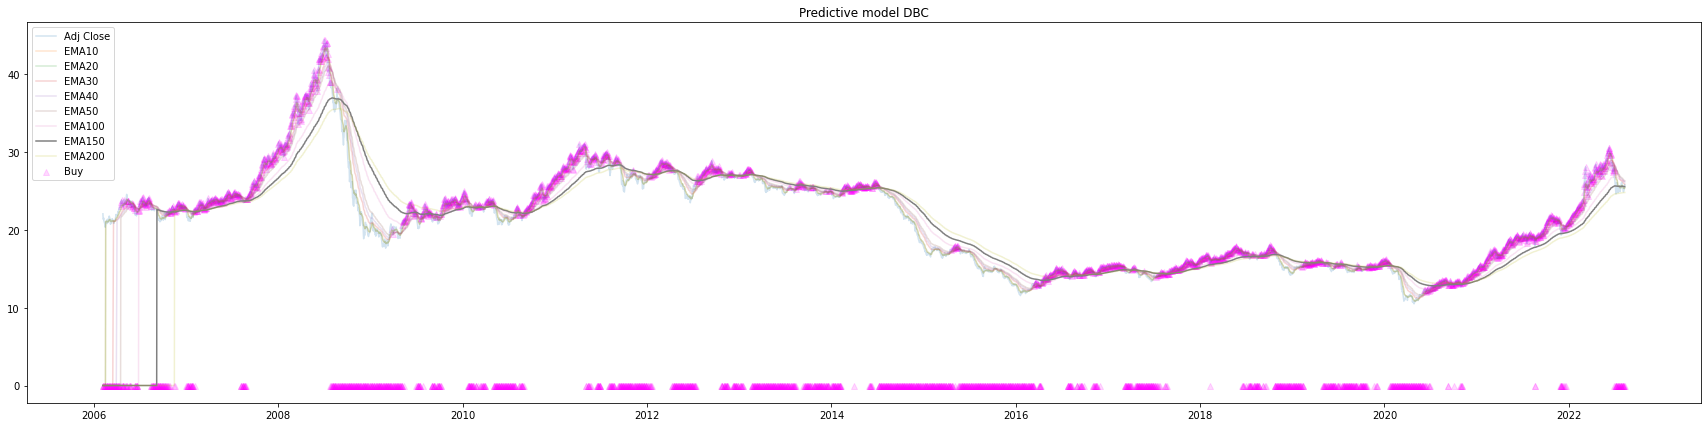

In [69]:
plot_stock_prediction(new_df, ticker)

In [70]:
new_df.shape

(4157, 48)

In [71]:
temp_df = new_df.loc[new_df["Date"] >= "2020-01-01", :]

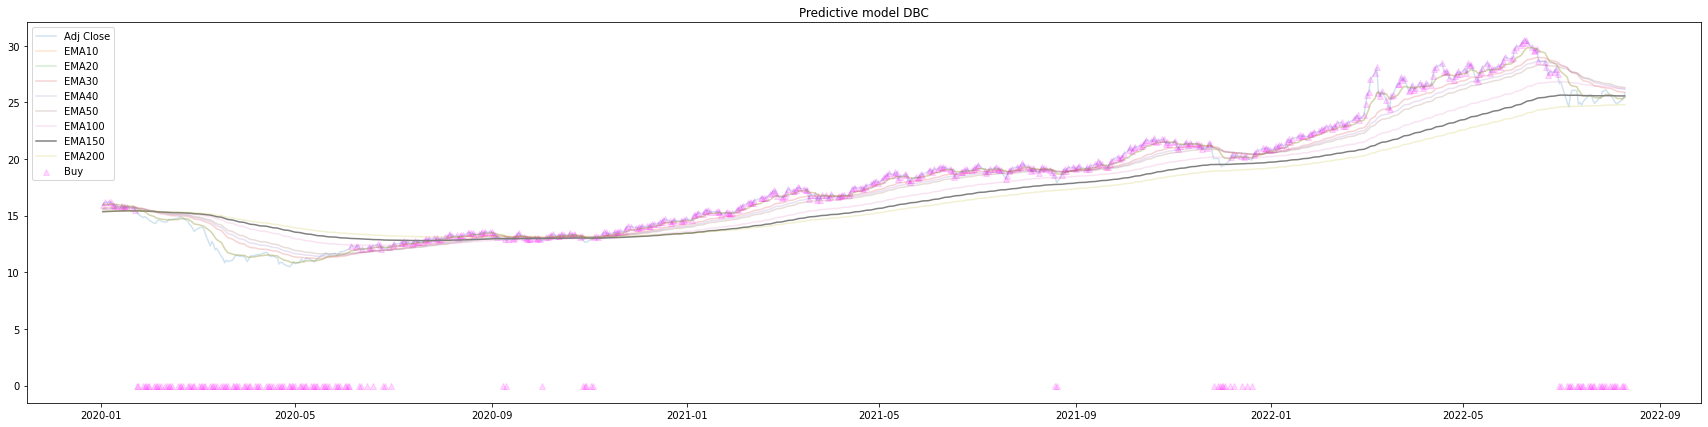

In [72]:
plot_stock_prediction(temp_df, ticker)